In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [35]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [9]:
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())

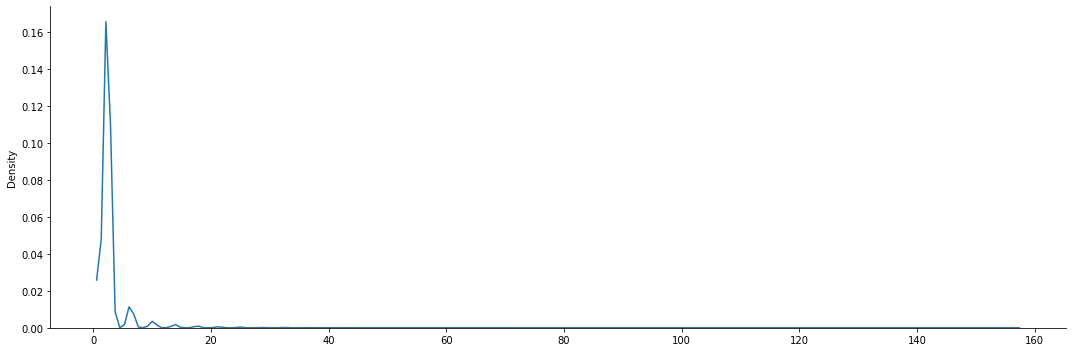

In [27]:
sns.displot(data=(qids.value_counts()), kind='kde', aspect=3)

In [28]:
from sklearn.metrics import log_loss

In [31]:
p = df_train['is_duplicate'].mean() # Our predicted probability
log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p)

0.6585273839844354

In [37]:
# simple answer
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('naive_submission.csv', index=False)
sub.head()

,test_id,is_duplicate
0,0,0.369198
1,1,0.369198
2,2,0.369198
3,3,0.369198
4,4,0.369198


In [39]:
len(df_test)

2345796

In [45]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

mean-train 59.82 std-train 31.96 mean-test 60.07 std-test 31.62 max-train 1169.00 max-test 1176.00


In [48]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))
print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

mean-train 11.06 std-train 5.89 mean-test 11.02 std-test 5.84 max-train 237.00 max-test 238.00


(-0.5, 1439.5, 1079.5, -0.5)

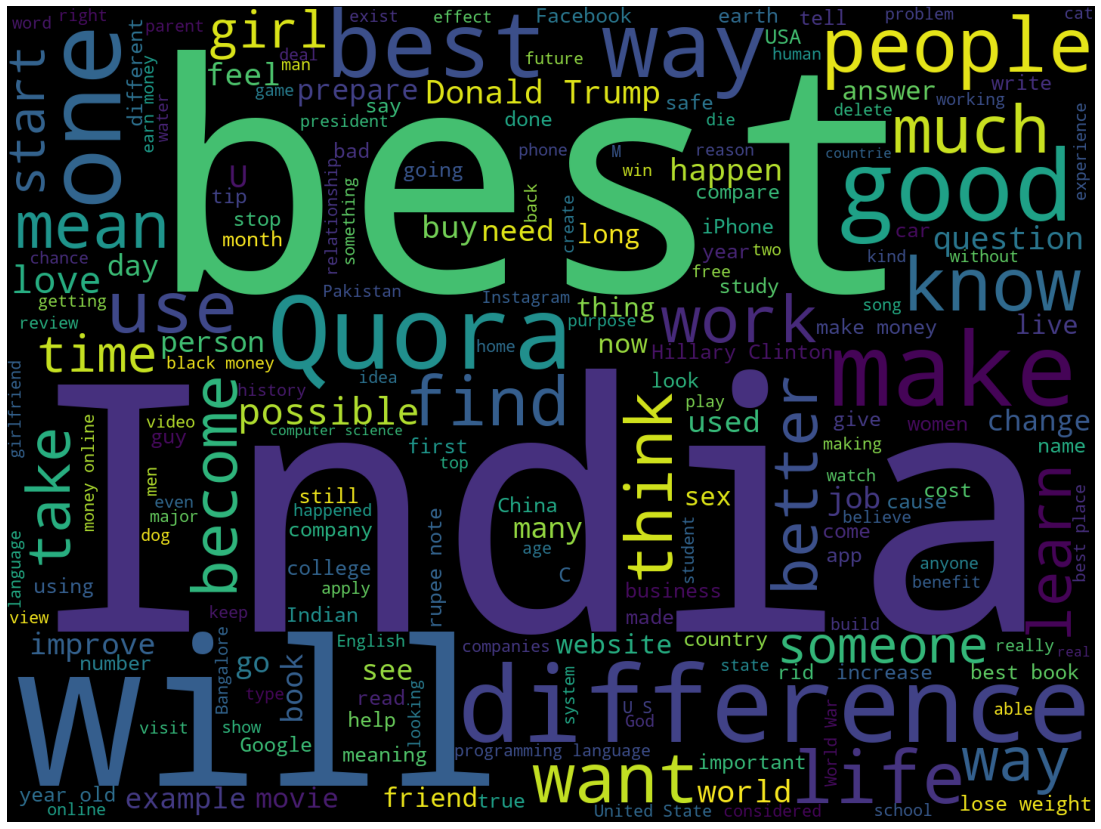

In [51]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [53]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


In [55]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhzhang/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [62]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R


train_word_match = df_train.apply(word_match_share, axis=1, raw=False)

In [64]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [72]:
len(weights)

201101

In [74]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=False)

/usr/local/var/pyenv/versions/3.6.12/envs/env36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [77]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.7804327049353577
   TFIDF AUC: 0.7704802292218704


In [91]:
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=False)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=False)

y_train = df_train['is_duplicate'].values

/usr/local/var/pyenv/versions/3.6.12/envs/env36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/var/pyenv/versions/3.6.12/envs/env36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [93]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [99]:
import xgboost as xgb

# Set our parameters for xgboost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.02,
    'max_depth': 4
}

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.68621	valid-logloss:0.68628
[10]	train-logloss:0.62972	valid-logloss:0.63028
[20]	train-logloss:0.58977	valid-logloss:0.59070
[30]	train-logloss:0.56057	valid-logloss:0.56171
[40]	train-logloss:0.53868	valid-logloss:0.54003
[50]	train-logloss:0.52200	valid-logloss:0.52351
[60]	train-logloss:0.50906	valid-logloss:0.51080
[70]	train-logloss:0.49910	valid-logloss:0.50089
[80]	train-logloss:0.49129	valid-logloss:0.49317
[90]	train-logloss:0.48519	valid-logloss:0.48720
[100]	train-logloss:0.48033	valid-logloss:0.48239
[110]	train-logloss:0.47649	valid-logloss:0.47862
[120]	train-logloss:0.47349	valid-logloss:0.47563
[130]	train-logloss:0.47096	valid-logloss:0.47325
[140]	train-logloss:0.46897	valid-logloss:0.47130
[150]	train-logloss:0.46740	valid-logloss:0.46977
[160]	train-logloss:0.46609	valid-logloss:0.46850
[170]	train-logloss:0.46499	valid-logloss:0.46746
[180]	train-logloss:0.46415	valid-logloss:0.46660
[190]	train-logloss:0.46345	valid-logloss:0.46593
[200]	train

In [102]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb.csv', index=False)

In [103]:
p_test

array([0.07485303, 0.58849454, 0.5879733 , ..., 0.00169077, 0.5642522 ,
       0.5671428 ], dtype=float32)